In [1]:
# Step 1: Import all necessary libraries
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
# Step 2: Load the dataset
# Assuming the CSV file is already available
data_path = "Data (2).csv"
df = pd.read_csv(data_path)


In [3]:
# Step 3: Explore the dataset
print("First 5 rows of the dataset:")
print(df.head())
print("\nDataset info:")
print(df.info())

First 5 rows of the dataset:
   14.23  1.71  2.43  15.6  127   2.8  3.06  0.28  2.29  5.64  1.04  3.92  \
0  13.20  1.78  2.14  11.2  100  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
1  13.16  2.36  2.67  18.6  101  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
2  14.37  1.95  2.50  16.8  113  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
3  13.24  2.59  2.87  21.0  118  2.80  2.69  0.39  1.82  4.32  1.04  2.93   
4  14.20  1.76  2.45  15.2  112  3.27  3.39  0.34  1.97  6.75  1.05  2.85   

   1065  
0  1050  
1  1185  
2  1480  
3   735  
4  1450  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   14.23   177 non-null    float64
 1   1.71    177 non-null    float64
 2   2.43    177 non-null    float64
 3   15.6    177 non-null    float64
 4   127     177 non-null    int64  
 5   2.8     177 non-null    float64
 6   3.06    177 non-null    flo

In [4]:
# Step 4: Handle Missing Values (if any)
print("\nMissing values in each column:")
print(df.isnull().sum())

# If there are any missing values, you can either fill or drop them. Here, we'll use mean imputation.
df.fillna(df.mean(), inplace=True)
print("\nAfter handling missing values (if any):")
print(df.isnull().sum())



Missing values in each column:
14.23    0
1.71     0
2.43     0
15.6     0
127      0
2.8      0
3.06     0
0.28     0
2.29     0
5.64     0
1.04     0
3.92     0
1065     0
dtype: int64

After handling missing values (if any):
14.23    0
1.71     0
2.43     0
15.6     0
127      0
2.8      0
3.06     0
0.28     0
2.29     0
5.64     0
1.04     0
3.92     0
1065     0
dtype: int64


In [5]:
# Step 5: Check for any duplicates
print("\nNumber of duplicate rows: ", df.duplicated().sum())

# Remove duplicates if they exist
df.drop_duplicates(inplace=True)
print("\nShape of data after removing duplicates: ", df.shape)


Number of duplicate rows:  0

Shape of data after removing duplicates:  (177, 13)


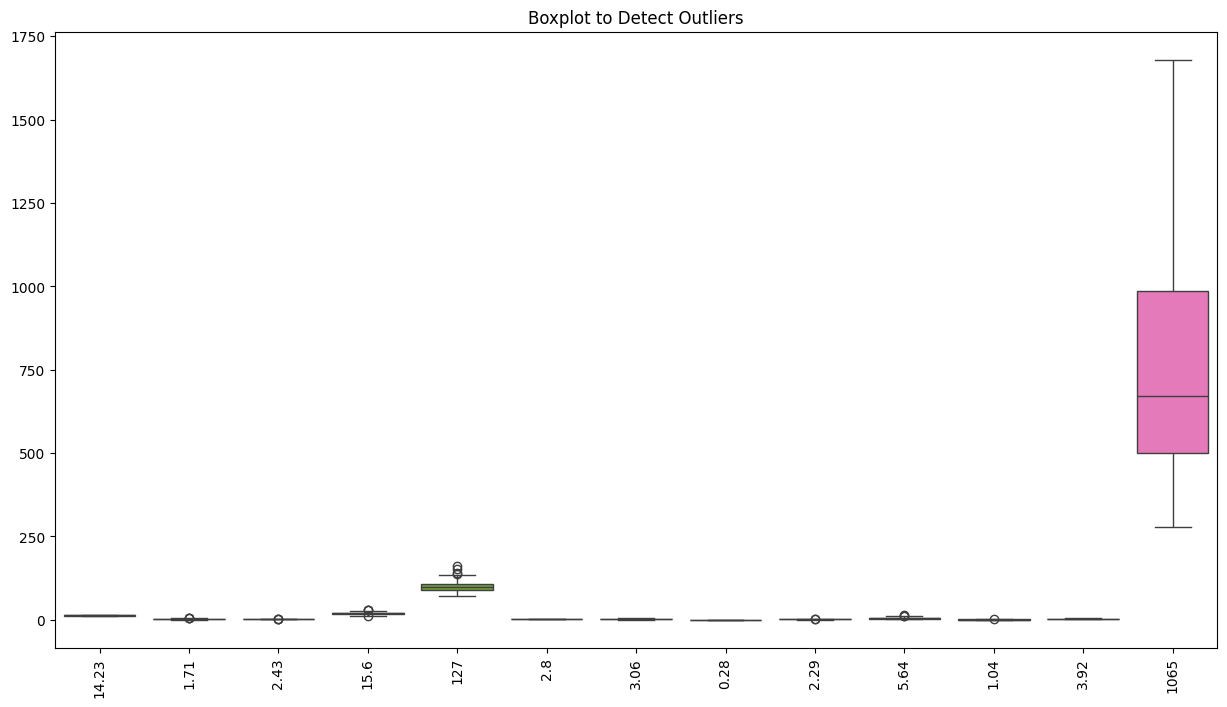

In [6]:
# Step 6: Check for outliers using boxplots
plt.figure(figsize=(15, 8))
sns.boxplot(data=df)
plt.title("Boxplot to Detect Outliers")
plt.xticks(rotation=90)
plt.show()

# You can handle outliers by capping, flooring, or removing them. Here's how to cap outliers using IQR.
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping outliers
df = df.clip(lower=lower_bound, upper=upper_bound, axis=1)

In [7]:
# Step 7: Data Preprocessing - Feature scaling (StandardScaler & MinMaxScaler)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# We can also try MinMaxScaler
min_max_scaler = MinMaxScaler()
data_normalized = min_max_scaler.fit_transform(df)

print("\nFirst 5 rows of the standardized data:")
print(pd.DataFrame(data_scaled, columns=df.columns).head())

print("\nFirst 5 rows of the normalized data (MinMax Scaling):")
print(pd.DataFrame(data_normalized, columns=df.columns).head())


First 5 rows of the standardized data:
      14.23      1.71      2.43      15.6       127       2.8      3.06  \
0  0.255824 -0.503688 -0.857922 -2.534555  0.050730  0.572666  0.739636   
1  0.206229  0.022930  1.150354 -0.274831  0.126185  0.812784  1.221645   
2  1.706501 -0.349334  0.506190 -0.824494  1.031650  2.493609  1.472691   
3  0.305420  0.231761  1.908194  0.458052  1.408927  0.812784  0.669343   
4  1.495719 -0.521847  0.316730 -1.313083  0.956195  1.565153  1.372273   

       0.28      2.29      5.64      1.04      3.92      1065  
0 -0.823139 -0.543695 -0.289694  0.411628  1.131698  0.971052  
1 -0.501337  2.209960  0.285222  0.323550  0.804579  1.400998  
2 -0.984039  1.076102  1.222777 -0.425113  1.202811  2.340509  
3  0.222716  0.428184 -0.316229  0.367589  0.463238 -0.032154  
4 -0.179536  0.698150  0.758422  0.411628  0.349457  2.244965  

First 5 rows of the normalized data (MinMax Scaling):
      14.23      1.71      2.43      15.6       127       2.8      3.0

In [8]:
# Step 8: Define a function to run KMeans and evaluate using multiple metrics
def run_kmeans(data, n_clusters):
    """Run KMeans and return model, labels, and evaluation metrics."""
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    
    # Evaluation metrics
    silhouette_avg = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    
    print(f"\nFor n_clusters = {n_clusters}:")
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index: {davies_bouldin}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz}")
    
    return kmeans, labels, silhouette_avg, davies_bouldin, calinski_harabasz


In [9]:
# Step 9: Try different numbers of clusters and evaluate
n_clusters_options = [2, 3, 4, 5, 6, 7, 8, 9, 10]
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for n_clusters in n_clusters_options:
    _, labels, silhouette, davies_bouldin, calinski_harabasz = run_kmeans(data_scaled, n_clusters)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)



For n_clusters = 2:
Silhouette Score: 0.2673167843230274
Davies-Bouldin Index: 1.4565973124527065
Calinski-Harabasz Score: 69.41364354466408

For n_clusters = 3:
Silhouette Score: 0.2841260175996656
Davies-Bouldin Index: 1.3863151518541368
Calinski-Harabasz Score: 71.44067791176117

For n_clusters = 4:
Silhouette Score: 0.2476141181014473
Davies-Bouldin Index: 1.7748974292003776
Calinski-Harabasz Score: 55.785118432052194

For n_clusters = 5:
Silhouette Score: 0.20375300401530957
Davies-Bouldin Index: 1.8531726782502869
Calinski-Harabasz Score: 46.58835103449025

For n_clusters = 6:
Silhouette Score: 0.15080655195486634
Davies-Bouldin Index: 2.0003421855020966
Calinski-Harabasz Score: 40.173708312841185

For n_clusters = 7:
Silhouette Score: 0.14235823951822857
Davies-Bouldin Index: 1.8546734077375409
Calinski-Harabasz Score: 36.10607651151434

For n_clusters = 8:
Silhouette Score: 0.14880275476723995
Davies-Bouldin Index: 1.9912861440284733
Calinski-Harabasz Score: 32.098326587446095

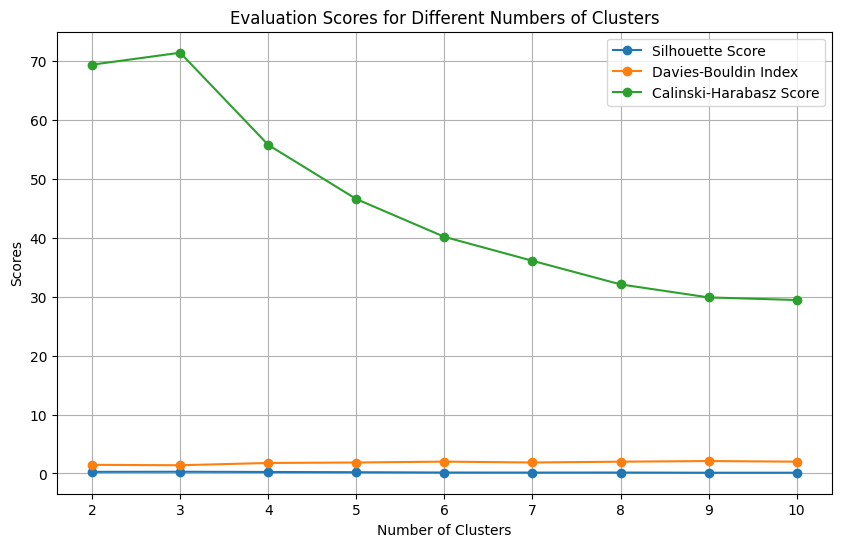

In [10]:
# Step 10: Plot silhouette scores to find the optimal number of clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_options, silhouette_scores, marker='o', label='Silhouette Score')
plt.plot(n_clusters_options, davies_bouldin_scores, marker='o', label='Davies-Bouldin Index')
plt.plot(n_clusters_options, calinski_harabasz_scores, marker='o', label='Calinski-Harabasz Score')
plt.title('Evaluation Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Scores')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Step 11: Choose the best number of clusters based on evaluation metrics
optimal_clusters = n_clusters_options[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters based on silhouette score: {optimal_clusters}")


Optimal number of clusters based on silhouette score: 3


In [12]:
# Step 12: Run KMeans with optimal number of clusters
kmeans, final_labels, _, _, _ = run_kmeans(data_scaled, optimal_clusters)



For n_clusters = 3:
Silhouette Score: 0.2841260175996656
Davies-Bouldin Index: 1.3863151518541368
Calinski-Harabasz Score: 71.44067791176117


In [13]:
# Step 13: Add cluster labels to the original dataframe
df['Cluster'] = final_labels

print("\nFirst 5 rows of the dataset with cluster labels:")
print(df.head())



First 5 rows of the dataset with cluster labels:
   14.23  1.71  2.43  15.6    127   2.8  3.06  0.28  2.29  5.64  1.04  3.92  \
0  13.20  1.78  2.14  11.2  100.0  2.65  2.76  0.26  1.28  4.38  1.05  3.40   
1  13.16  2.36  2.67  18.6  101.0  2.80  3.24  0.30  2.81  5.68  1.03  3.17   
2  14.37  1.95  2.50  16.8  113.0  3.85  3.49  0.24  2.18  7.80  0.86  3.45   
3  13.24  2.59  2.87  21.0  118.0  2.80  2.69  0.39  1.82  4.32  1.04  2.93   
4  14.20  1.76  2.45  15.2  112.0  3.27  3.39  0.34  1.97  6.75  1.05  2.85   

   1065  Cluster  
0  1050        2  
1  1185        2  
2  1480        2  
3   735        2  
4  1450        2  


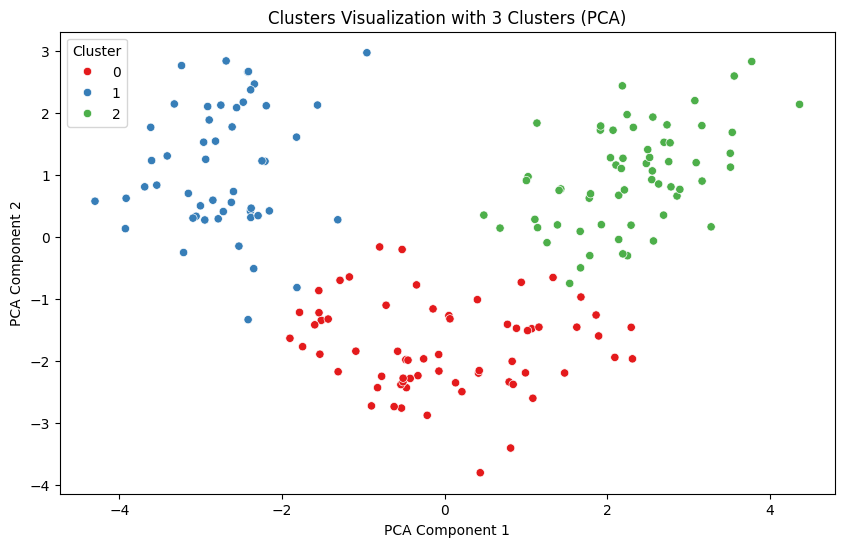

In [14]:
# Step 14: Visualize the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df['Cluster'], palette='Set1')
plt.title(f'Clusters Visualization with {optimal_clusters} Clusters (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [15]:
# Step 15: Evaluate clusters - cluster sizes
cluster_sizes = df['Cluster'].value_counts()
print("\nCluster sizes:")
print(cluster_sizes)


Cluster sizes:
Cluster
0    65
2    61
1    51
Name: count, dtype: int64


In [16]:
# Step 16: Evaluate clusters - Mean values of features in each cluster
cluster_means = df.groupby('Cluster').mean()
print("\nMean values of features in each cluster:")
print(cluster_means)


Mean values of features in each cluster:
             14.23      1.71      2.43       15.6         127       2.8  \
Cluster                                                                   
0        12.250923  1.890462  2.236231  20.056923   92.492308  2.247692   
1        13.134118  3.298235  2.417647  21.241176   98.666667  1.683922   
2        13.667705  2.002623  2.462295  17.450820  107.163934  2.848361   

             3.06      0.28      2.29      5.64      1.04      3.92  \
Cluster                                                               
0        2.050000  0.357692  1.615231  2.973077  1.061477  2.803385   
1        0.818824  0.451961  1.145882  7.166176  0.691961  1.696667   
2        3.002295  0.292295  1.911475  5.450492  1.065902  3.150984   

                1065  
Cluster               
0         510.169231  
1         619.058824  
2        1100.803279  


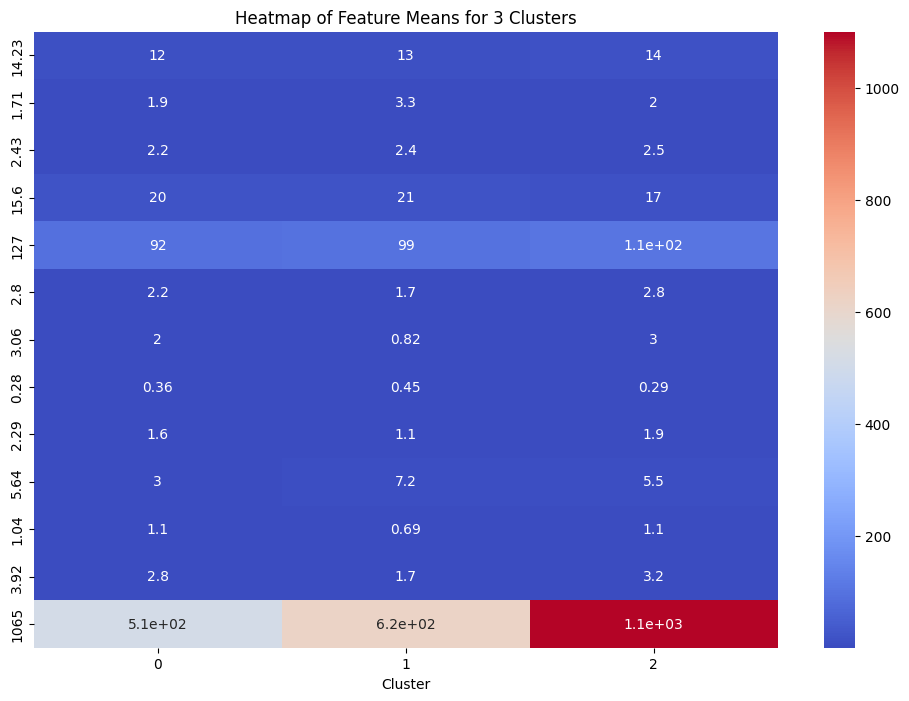

In [17]:
# Step 17: Visualize cluster means for each feature
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap='coolwarm')
plt.title(f'Heatmap of Feature Means for {optimal_clusters} Clusters')
plt.show()

C:\Users\Gajen\AppData\Local\Temp\ipykernel_11876\3462026129.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df, palette='Set2')


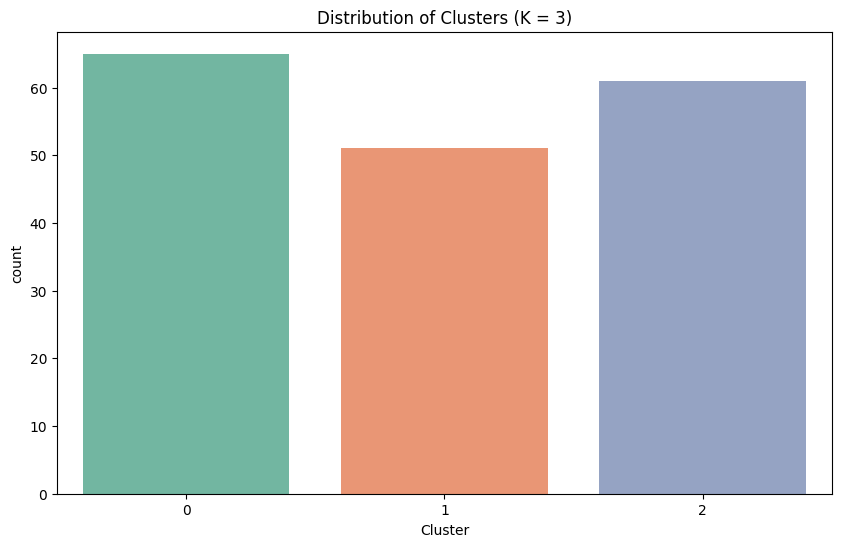

In [18]:

# Step 18: Additional Cluster Evaluation - Distribution of clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', data=df, palette='Set2')
plt.title(f'Distribution of Clusters (K = {optimal_clusters})')
plt.show()

In [19]:
# Step 19: Conclusion - Summarize insights from clustering
print(f"\nSummary of clustering with {optimal_clusters} clusters:")
print("- Cluster sizes:")
print(cluster_sizes)
print("\n- Mean values of features in each cluster:")
print(cluster_means)


Summary of clustering with 3 clusters:
- Cluster sizes:
Cluster
0    65
2    61
1    51
Name: count, dtype: int64

- Mean values of features in each cluster:
             14.23      1.71      2.43       15.6         127       2.8  \
Cluster                                                                   
0        12.250923  1.890462  2.236231  20.056923   92.492308  2.247692   
1        13.134118  3.298235  2.417647  21.241176   98.666667  1.683922   
2        13.667705  2.002623  2.462295  17.450820  107.163934  2.848361   

             3.06      0.28      2.29      5.64      1.04      3.92  \
Cluster                                                               
0        2.050000  0.357692  1.615231  2.973077  1.061477  2.803385   
1        0.818824  0.451961  1.145882  7.166176  0.691961  1.696667   
2        3.002295  0.292295  1.911475  5.450492  1.065902  3.150984   

                1065  
Cluster               
0         510.169231  
1         619.058824  
2        1100.803

In [20]:
# Final words on cluster evaluation
print("\nAdditional evaluation insights:")
print(f"- The silhouette score provides a measure of how similar an object is to its own cluster compared to other clusters.")
print(f"- The Davies-Bouldin index represents the ratio of within-cluster distances to between-cluster distances.")
print(f"- The Calinski-Harabasz score represents the ratio of the sum of between-cluster dispersion to within-cluster dispersion.")



Additional evaluation insights:
- The silhouette score provides a measure of how similar an object is to its own cluster compared to other clusters.
- The Davies-Bouldin index represents the ratio of within-cluster distances to between-cluster distances.
- The Calinski-Harabasz score represents the ratio of the sum of between-cluster dispersion to within-cluster dispersion.
